In [208]:

import sys,os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils.pg import PgClass
from src.constants import project_dir, DATABASE_DB, DATABASE_USER, DATABASE_PW, DATABASE_HOST, DATABASE_PORT

import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.stats import rankdata

from dateutil.relativedelta import relativedelta
import datetime
import holidays

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.express as px

from itertools import cycle


import IPython
import IPython.display
from IPython.display import display, HTML, Markdown
from IPython.display import clear_output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x:'%.4f'%x)
import warnings
warnings.filterwarnings("ignore")



In [209]:
pg_conn = PgClass(DATABASE_DB, DATABASE_USER, DATABASE_PW, DATABASE_HOST, DATABASE_PORT)


In [210]:
#configurations

start_date = '2014-01-01'
train_start_date_input, train_end_date_input = datetime.date(2014, 1, 1), datetime.datetime.today().date()
n_forecast =30
n_input_width=30
# one of 'VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU', 'QQQ'
target_etf = 'VFH'


## Collect data

In [211]:
leading_q = f"""
SELECT fc.metric, activity_date, value, frequency, title
FROM fred.fact_metric fc
JOIN fred.dim_metric dim
ON fc.metric = dim.metric
WHERE activity_date >='{start_date}'
AND fc.metric in ('M2', 'T10YFF', 'DGS10', 'SP500', 'UMCSENT', 'PERMIT','ANDENO','AWHAEMAN','DTCDISA066MSFRBNY'
--,'ICSA'
);
             """
leading_df = pd.read_sql_query(leading_q, pg_conn.connection)

In [212]:
etf_q = f"""
select ticker, activity_date, close
from stock.fact_stock_price
where activity_date >='{start_date}'
 and ticker in ('VOX', 'VCR', 'VDC', 'VDE', 'VFH', 'VHT', 'VIS', 'VGT', 'VAW', 'VNQ', 'VPU','QQQ')"""
etf_df = pd.read_sql_query(etf_q, pg_conn.connection)

In [213]:
# pivots the leading indicators and etf to predict
leading_metric_df = leading_df.groupby(['metric','frequency','title']
                                      ).count().index.to_frame(index=False, name=['metric','frequency','title'])
leading_pivoted = pd.pivot_table(leading_df, index='activity_date', columns='metric', values='value',aggfunc='sum').reset_index()

etf_pivoted = pd.pivot_table(etf_df, index='activity_date',columns='ticker',values='close',aggfunc='sum').reset_index()


In [214]:
data_df = etf_pivoted.merge(leading_pivoted, on=['activity_date'], how='outer')\
            .sort_values(by=['activity_date'])\
            .reset_index(drop=True)

In [215]:
data_df = data_df.set_index('activity_date').asfreq('D')
data_df.index = data_df.index.date
etf_list = etf_df.ticker.unique().tolist()
# TODO:
# etf_list=['VFH']
leading_metric_list = leading_metric_df.metric.unique().tolist()
# replace the fred metric with 0 value to null
data_df = data_df.replace(0,np.nan)
# forwardfill then backwardfill null value to fill all null value
data_df = data_df.fillna(method='ffill').dropna()

In [216]:
# create date_features
data_df['weekday']=data_df.index.map(lambda x:x.weekday())
data_df['is_weekend'] = np.where(data_df['weekday'].isin([0,6]),1,0)
us_holidays = holidays.UnitedStates()
data_df['is_holiday']=data_df.index.map(lambda x: 1 if x in us_holidays else 0)
date_feature_list = ['weekday','is_weekend','is_holiday']

## Explore Data

In [217]:
def plot_trends(df):
    for i in df.columns:
        plt.figure(figsize=(6,2))
        plt.plot(df.index, df[i])
        plt.title(i)
        plt.show()

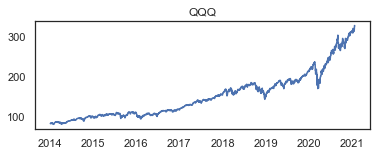

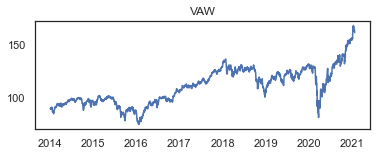

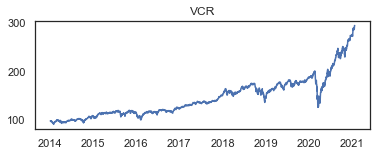

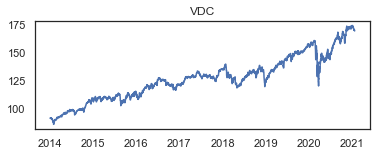

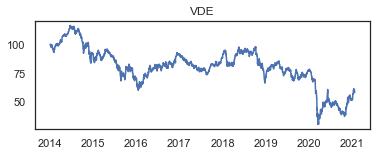

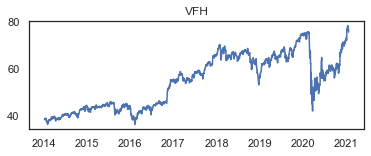

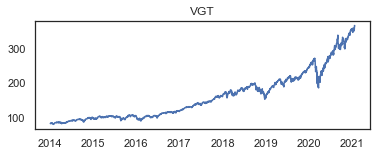

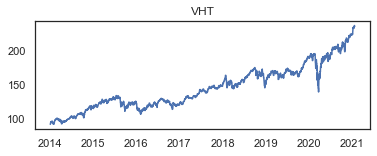

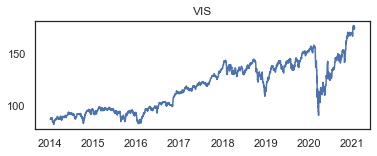

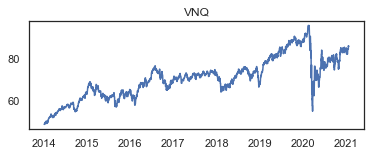

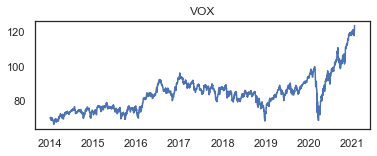

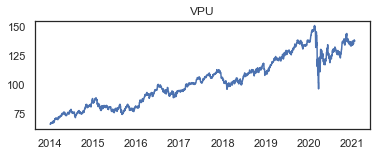

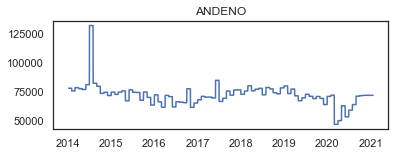

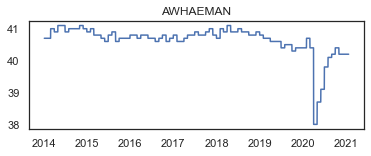

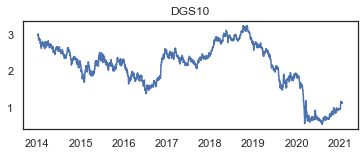

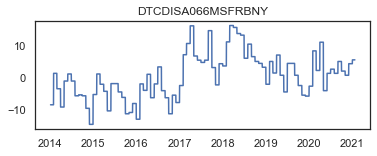

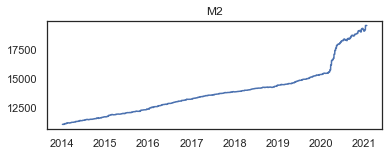

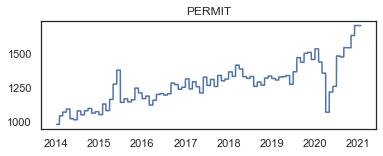

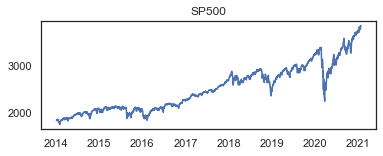

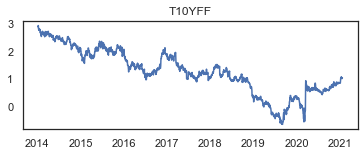

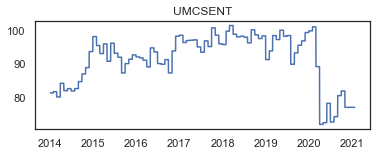

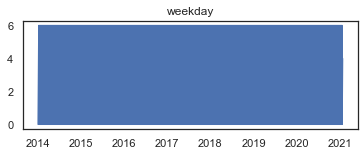

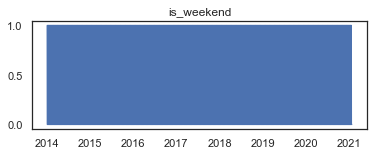

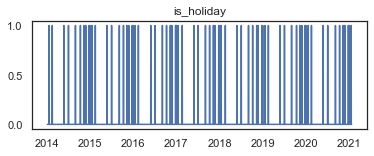

In [218]:
plot_trends(data_df)

<AxesSubplot:>

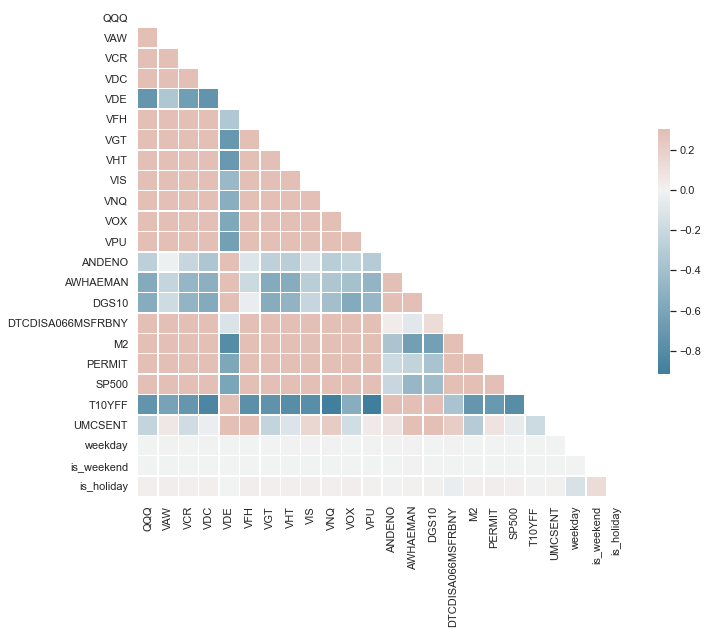

In [219]:
# correlation matrix
sns.set_theme(style="white")


# Compute the correlation matrix
corr = data_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [220]:
# corr[target_etf].sort_values()

## Create dataset for prediction

In [221]:
# use related data for model
data_start_date = data_df.index.min()
data_end_date = data_df.index.max()
train_start_date = max(data_start_date, train_start_date_input) 
train_end_date = min(data_end_date, train_end_date_input)
# for deep learning model in this Notebook, the forecast period is decided by n_input_width rather than n_forecast
forecast_start_date, forecast_end_date = train_end_date+relativedelta(days=1), train_end_date+relativedelta(days=1+n_forecast)

df = data_df.loc[(data_df.index>= train_start_date) & (data_df.index<= train_end_date),
             etf_list+leading_metric_list+date_feature_list].copy()


## VAR

In [222]:
diff_order = 1
diff_df = df.diff(diff_order).dropna()
diff_df.columns = [ i +'_diff' for i in diff_df.columns]

In [223]:
# Stationary test
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

for name, column in diff_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "QQQ_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7386
 No. Lags Chosen       = 23
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "VOX_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.9028
 No. Lags Chosen       = 23
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "VCR_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

    Augmented Dickey-Fuller Test on "weekday_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1922698002267227.0
 No. Lags Chosen       = 5
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "is_weekend_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4588232906083548.0
 No. Lags Chosen       = 5
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "is_holiday_diff" 
    -----------------------------------------------
 Null Hypothesis: Data has uni

In [224]:
def test_stationarity(timeseries, label, title):
    '''
    function to test  stationary
    '''
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,6))
    orig = plt.plot(timeseries, color='black',label=label)
    #mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()
    
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in list(dftest[4].items()):
        dfoutput['Critical Value (%s)'%key] = value
    if dfoutput['p-value']<=0.05:
        conclusion = "stationary"
    else:
        conclusion = "not stationary"
    print("Dickey-Fuller Test: " + conclusion)
    dfoutput = dfoutput.reset_index()
    dfoutput.columns=['metric', 'value']
    display(HTML(dfoutput.to_html()))
    
    return


QQQ_diff


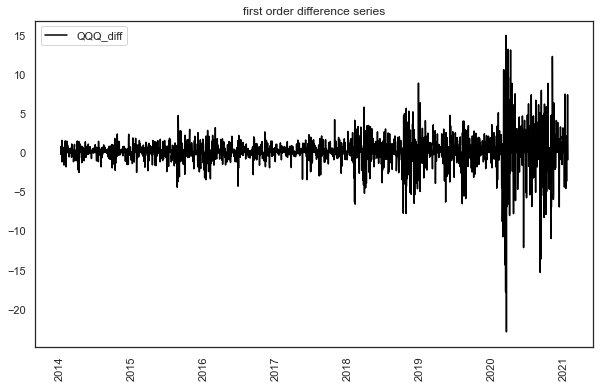

Dickey-Fuller Test: stationary


VOX_diff


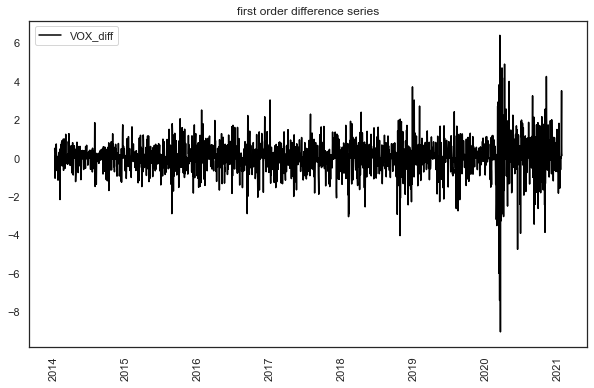

Dickey-Fuller Test: stationary


VCR_diff


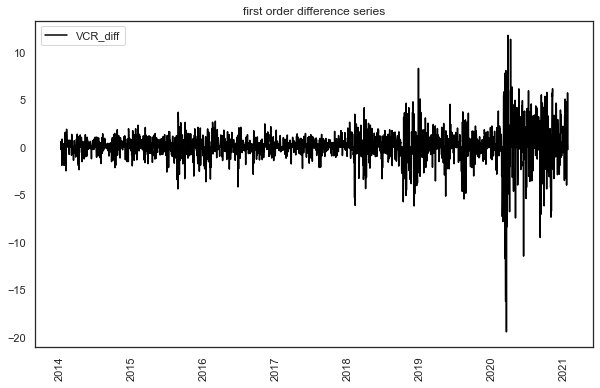

Dickey-Fuller Test: stationary


VDC_diff


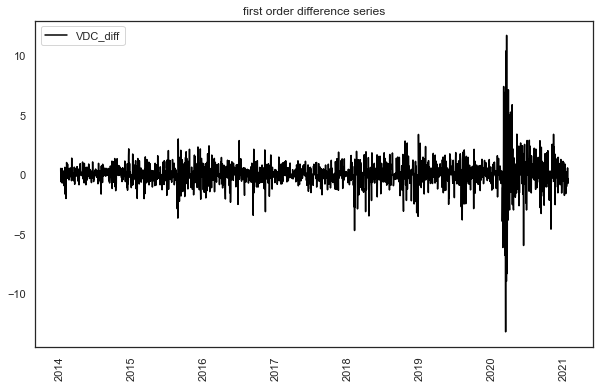

Dickey-Fuller Test: stationary


VDE_diff


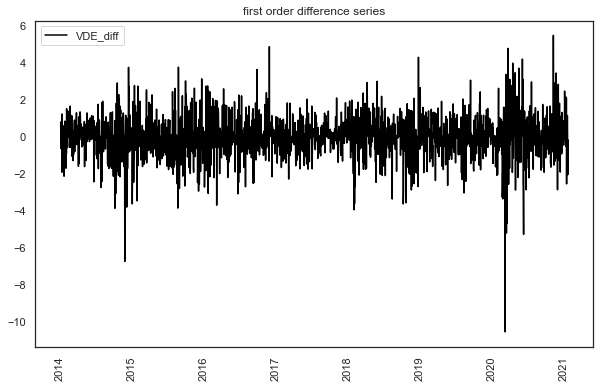

Dickey-Fuller Test: stationary


VFH_diff


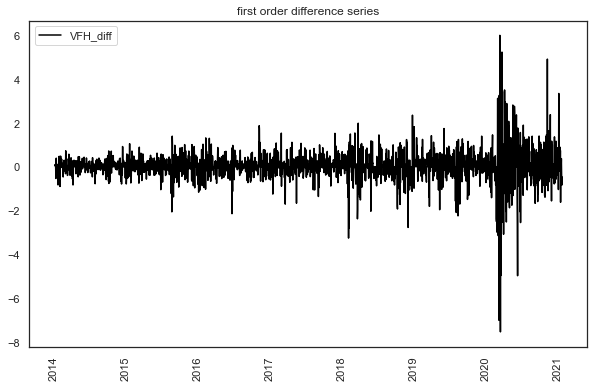

Dickey-Fuller Test: stationary


VHT_diff


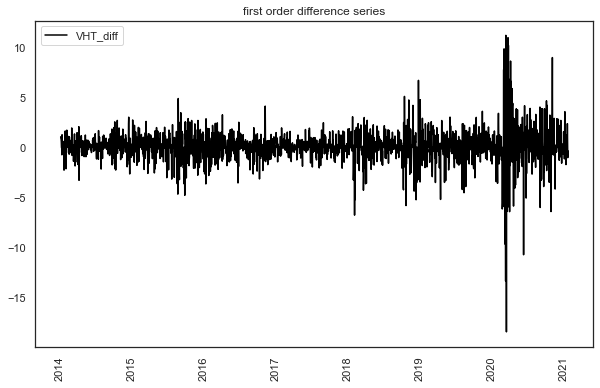

Dickey-Fuller Test: stationary


VIS_diff


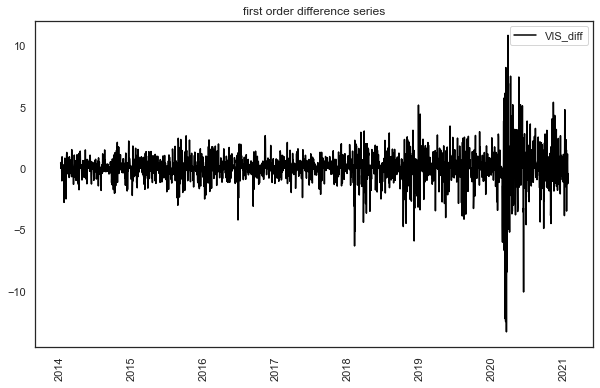

Dickey-Fuller Test: stationary


VGT_diff


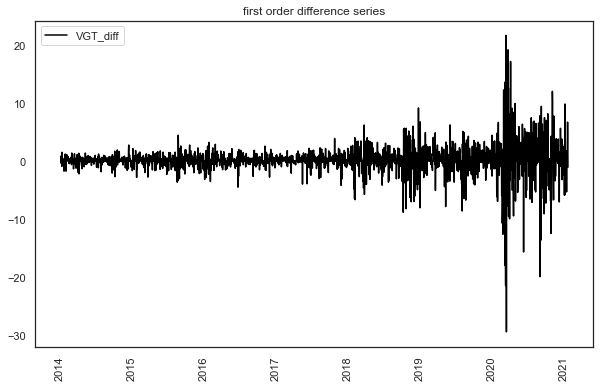

Dickey-Fuller Test: stationary


VAW_diff


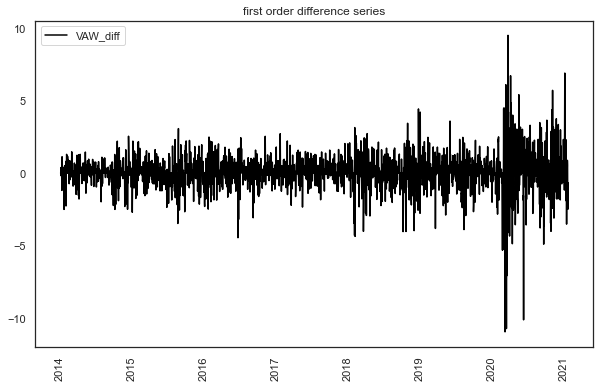

Dickey-Fuller Test: stationary


VNQ_diff


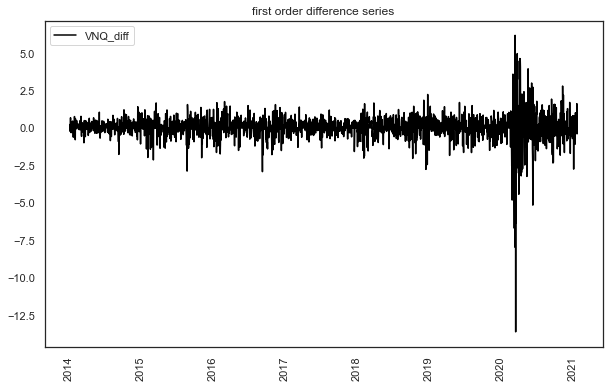

Dickey-Fuller Test: stationary


VPU_diff


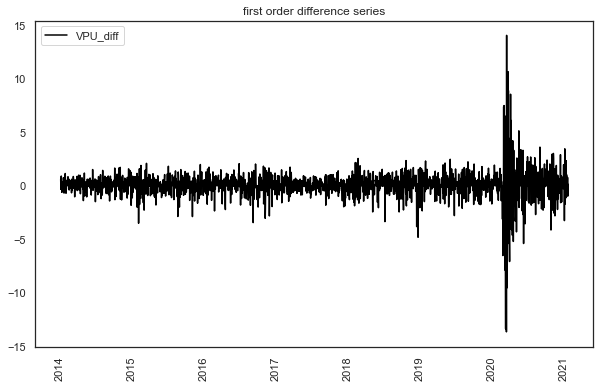

Dickey-Fuller Test: stationary


ANDENO_diff


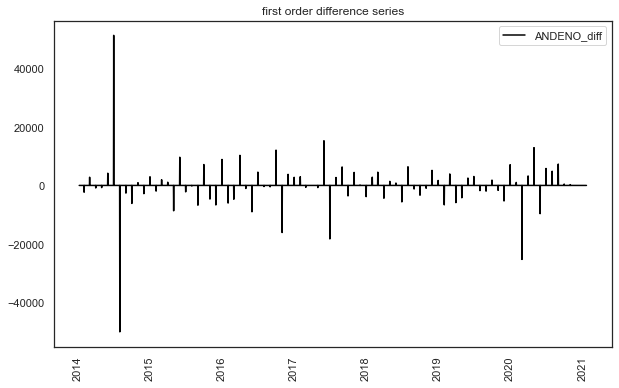

Dickey-Fuller Test: stationary


AWHAEMAN_diff


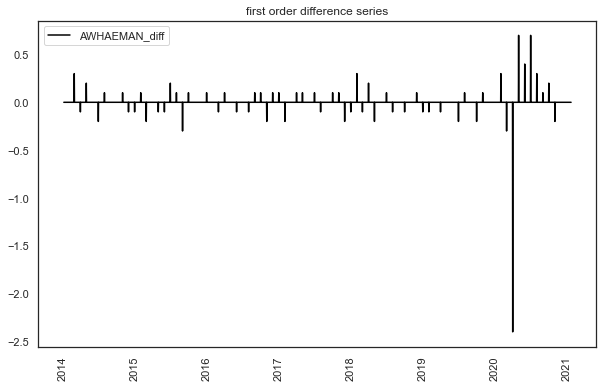

Dickey-Fuller Test: stationary


DGS10_diff


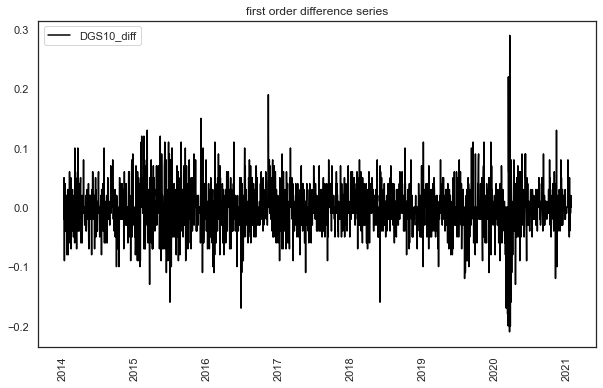

Dickey-Fuller Test: stationary


DTCDISA066MSFRBNY_diff


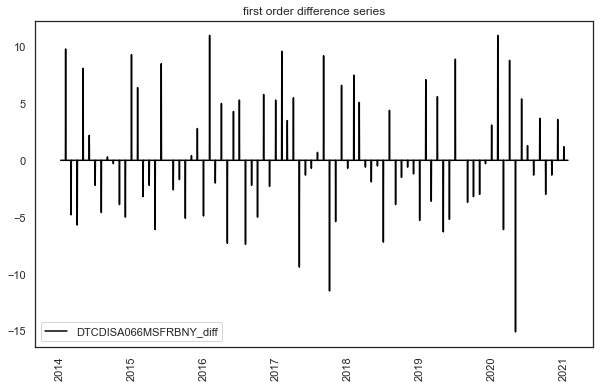

Dickey-Fuller Test: stationary


M2_diff


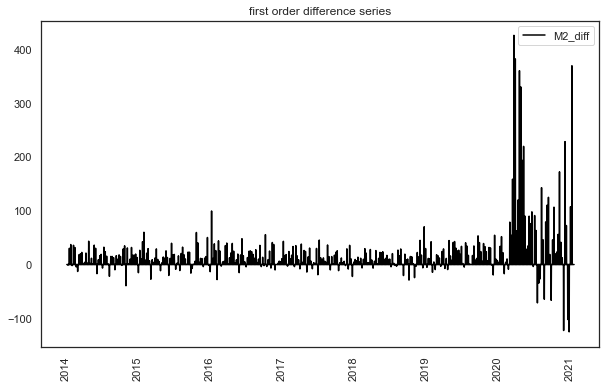

Dickey-Fuller Test: stationary


PERMIT_diff


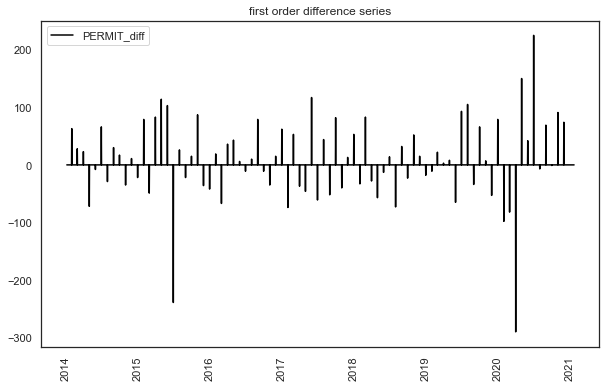

Dickey-Fuller Test: stationary


SP500_diff


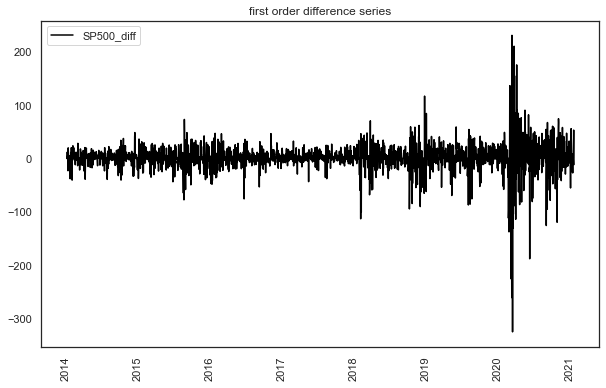

Dickey-Fuller Test: stationary


T10YFF_diff


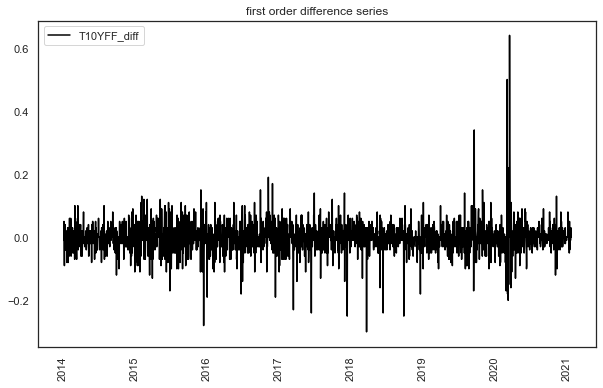

Dickey-Fuller Test: stationary


UMCSENT_diff


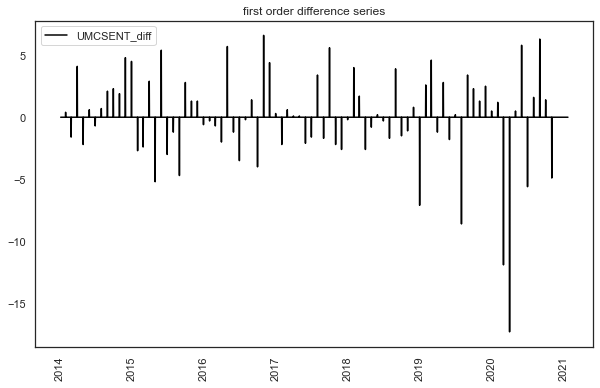

Dickey-Fuller Test: stationary


weekday_diff


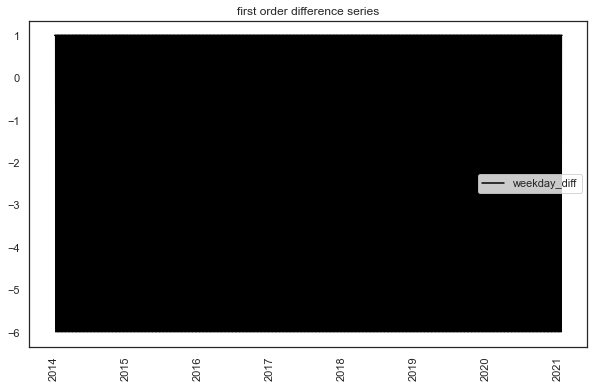

Dickey-Fuller Test: stationary


is_weekend_diff


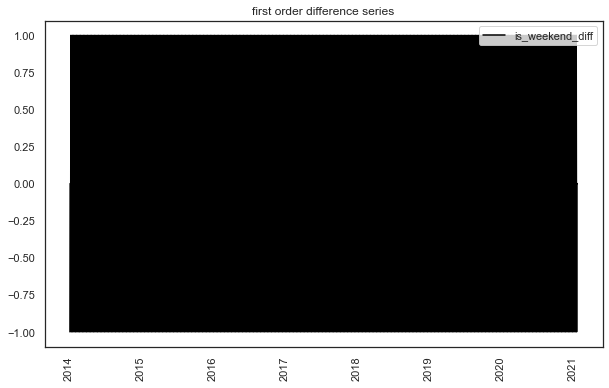

Dickey-Fuller Test: stationary


is_holiday_diff


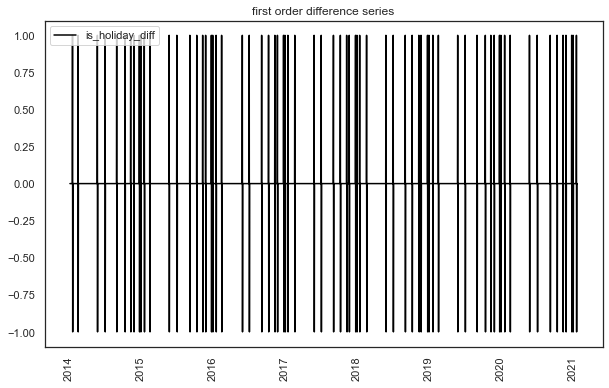

Dickey-Fuller Test: stationary


In [225]:
_ = diff_df
for col in _.columns:
    print(col)
    test_stationarity(_[col], label=col, title='first order difference series')


## VAR model

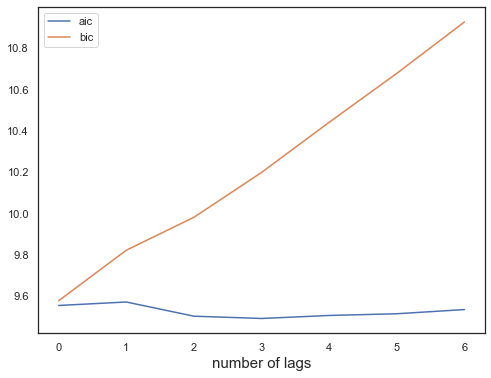

In [226]:

train_df_var = diff_df[[target_etf+"_diff"]+[i+'_diff' for i in leading_metric_list]].copy()

model = VAR(train_df_var)
aic, bic = [], []

x = np.arange(7)
for i in x:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)

plt.figure(figsize=(8,6))
plt.plot(x, aic, label='aic')
plt.plot(x, bic, label='bic')
plt.xlabel("number of lags", fontsize=15)
plt.legend()
plt.show()


In [227]:
# actually, this is not a good example of using VAR model
maxlags = 7
model_result_var = model.fit(maxlags=maxlags, ic = 'bic', trend = 'c')  #do not use linear trend since it stationarized after differencing
num_lag_chosen = model_result_var.k_ar
print(num_lag_chosen)

print(model_result_var.summary())


0
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Jan, 2021
Time:                     22:08:57
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    9.57846
Nobs:                     2573.00    HQIC:                   9.56396
Log likelihood:          -48792.7    FPE:                    14125.1
AIC:                      9.55571    Det(Omega_mle):         14070.4
--------------------------------------------------------------------
Results for equation VFH_diff
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.014307         0.012895            1.109           0.267

Results for equation ANDENO_diff
           coefficient       std. error           t-stat            prob
-----------------------------------------------------

## Tensorflow Models
This part is mainly copied from this [page](https://www.tensorflow.org/tutorials/structured_data/time_series#top_of_page). I changed the data transformation method to make the time series stationary.

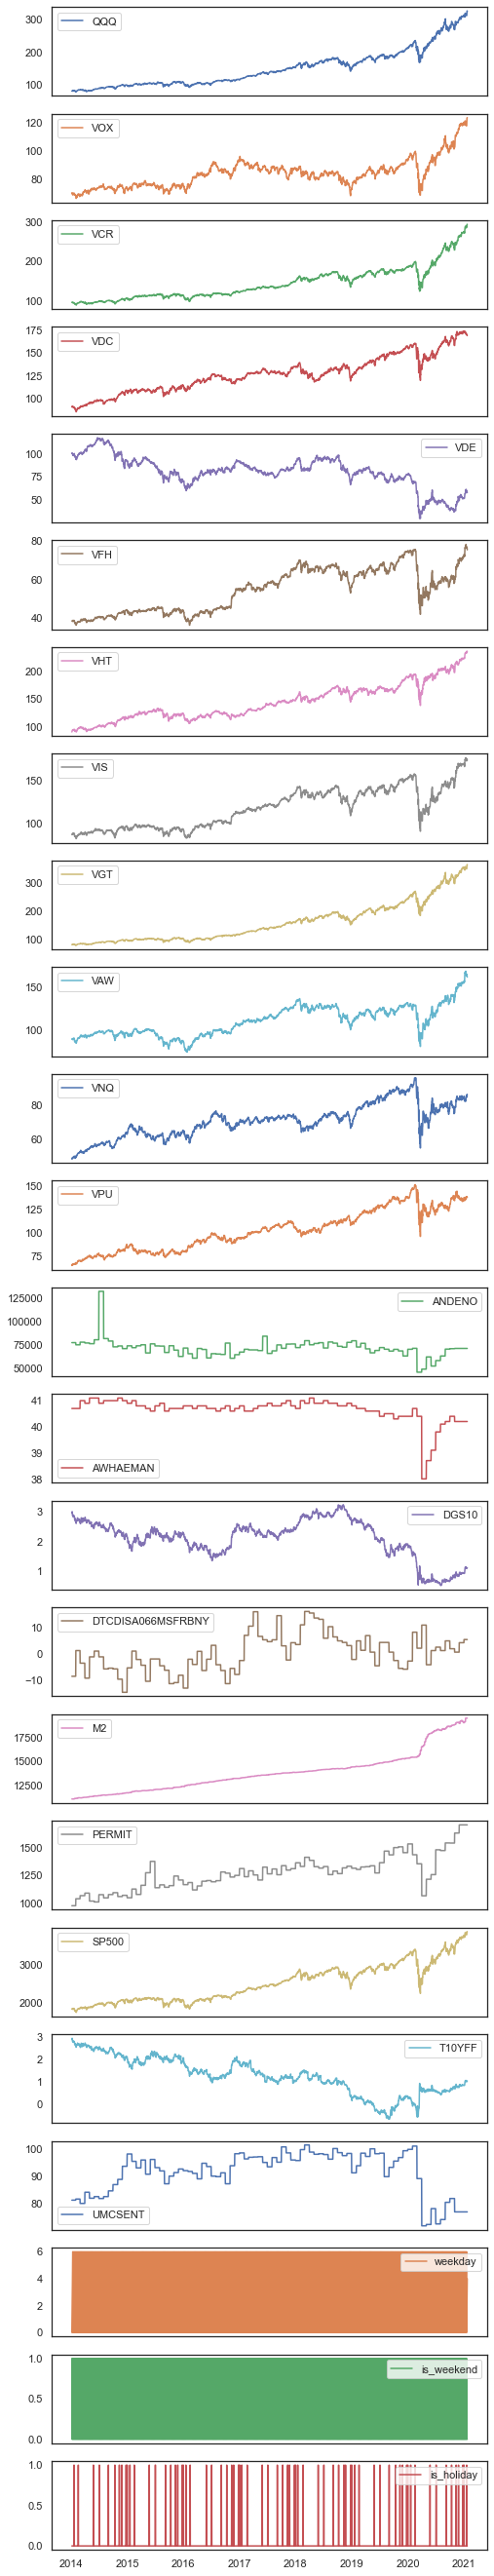

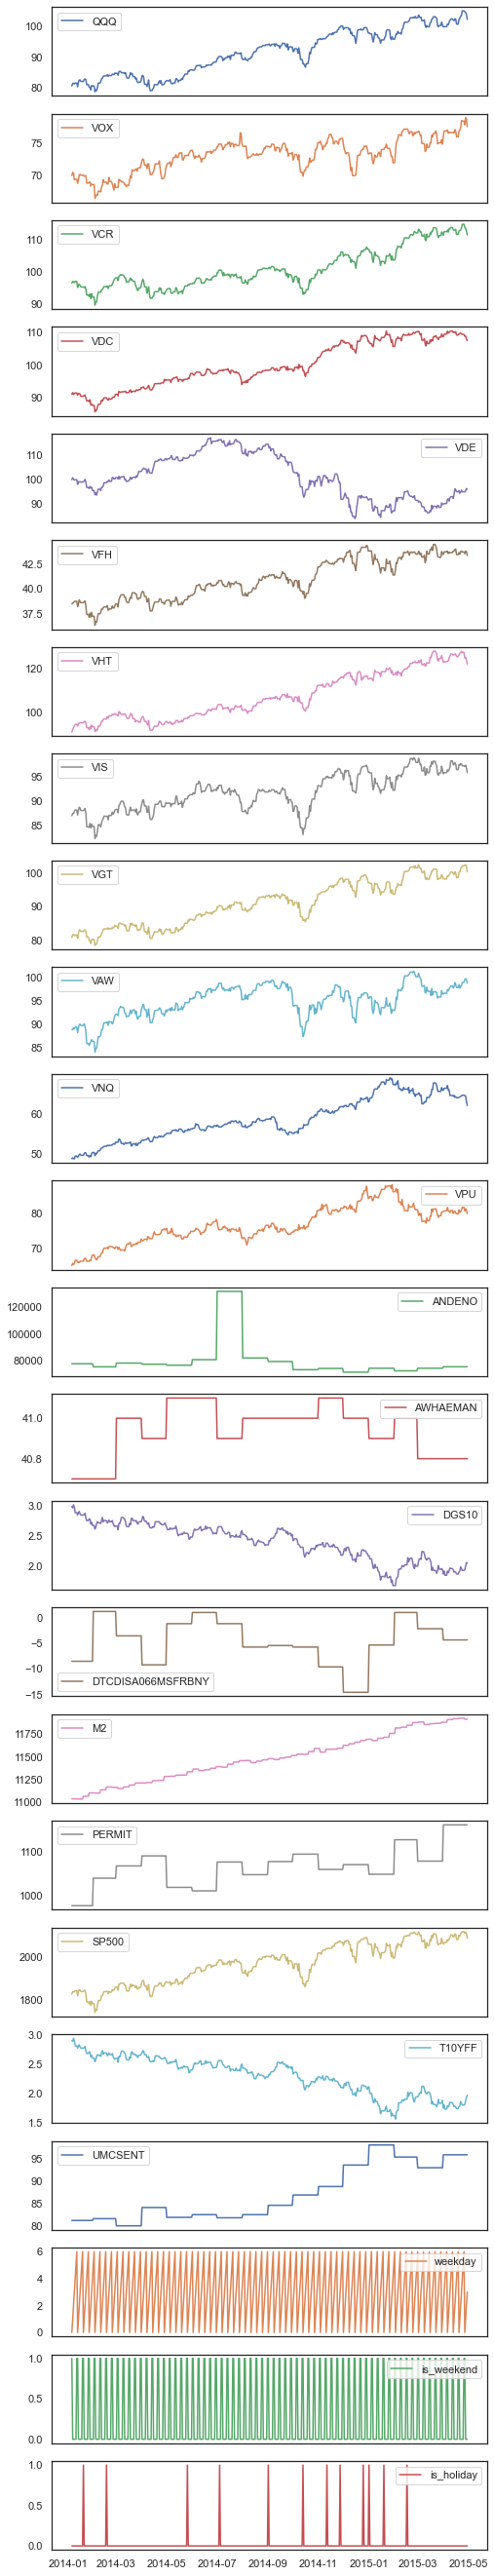

In [228]:

plot_cols = etf_list+leading_metric_list+date_feature_list
mpl.rcParams['figure.figsize'] = (8, len(plot_cols)*2)
mpl.rcParams['axes.grid'] = False

plot_features = df[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
# plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

mpl.rcParams['figure.figsize'] = (8, 6)


In [229]:
df.describe().transpose()


count       mean       std        min        25%  \
QQQ               2574.0000   149.5422   56.7887    78.7702   102.9113   
VOX               2574.0000    83.7895   10.0594    66.3150    75.6871   
VCR               2574.0000   144.0238   41.0171    89.5402   113.2885   
VDC               2574.0000   126.4369   19.7373    85.5232   110.6015   
VDE               2574.0000    80.5074   16.7342    30.1825    73.9889   
VFH               2574.0000    54.3452   11.1572    36.3279    43.5061   
VHT               2574.0000   144.1069   31.9417    91.0168   119.9674   
VIS               2574.0000   117.4233   22.7258    82.2855    95.5301   
VGT               2574.0000   158.3126   68.7372    78.5967   100.4102   
VAW               2574.0000   110.0543   17.3404    73.7096    95.7232   
VNQ               2574.0000    70.5979    9.5336    48.8140    63.7769   
VPU               2574.0000   102.3222   21.1198    65.2132    81.2999   
ANDENO            2574.0000 71618.4981 9390.6386 46151.0000 68551.0000   
AWHAEMAN          2574.0000    40.6434    0.4691    38.0000    40.6000   
DGS10             2574.0000     2.1024    0.6474     0.5200     1.7800   
DTCDISA066MSFRBNY 2574.0000     0.3953    7.0133   -14.6000    -4.5000   
M2                2574.0000 13819.2059 2056.4282 11034.9000 12158.0500   
PERMIT            2574.0000  1272.0820  154.5536   976.0000  1161.0000   
SP500             2574.0000  2499.6564  489.9623  1741.8900  2072.7925   
T10YFF            2574.0000     1.2531    0.8115    -0.6600     0.6725   
UMCSENT           2574.0000    91.4896    7.6313    71.8000    87.2000   
weekday           2574.0000     2.9981    1.9999     0.0000     1.0000   
is_weekend        2574.0000     0.2855    0.4518     0.0000     0.0000   
is_holiday        2574.0000     0.0299    0.1704     0.0000     0.0000   

                         50%        75%         max  
QQQ                 138.3103   180.6104    326.3600  
VOX                  83.7300    88.0855    123.5400  
VCR                 134.6477   168.3702    294.1000  
VDC                 126.7680   137.7978    173.9200  
VDE                  81.6833    91.2633    117.0020  
VFH                  55.5991    64.5170     78.1100  
VHT                 139.5485   166.0876    235.6800  
VIS                 117.6787   136.2748    176.3600  
VGT                 140.5449   197.1905    364.8600  
VAW                 110.5430   124.0468    168.4900  
VNQ                  70.6815    75.8742     95.5405  
VPU                 101.0695   120.3645    151.0158  
ANDENO            71483.0000 75244.0000 131973.0000  
AWHAEMAN             40.7000    40.9000     41.1000  
DGS10                 2.2400     2.5475      3.2400  
DTCDISA066MSFRBNY     0.7000     5.0000     16.2000  
M2                13607.5000 14549.7000  19548.1000  
PERMIT             1271.0000  1338.0000   1709.0000  
SP500              2435.8550  2853.5675   3853.0700  
T10YFF                1.2300     1.9200      2.9400  
UMCSENT              93.5000    97.5000    101.4000  
weekday               3.0000     5.0000      6.0000  
is_weekend            0.0000     1.0000      1.0000  
is_holiday            0.0000     0.0000      1.0000

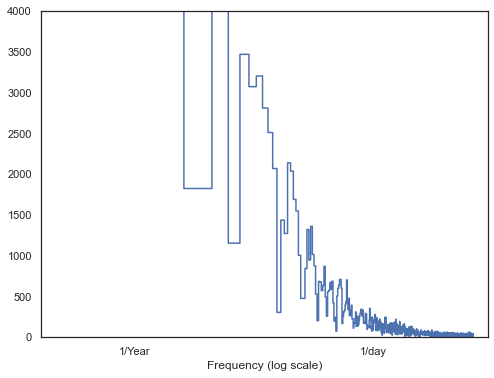

In [230]:
# determine which frequencies are important using an fft
fft = tf.signal.rfft(df[target_etf])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df[target_etf])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 4000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [231]:
# split data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)].copy()
val_df = df[int(n*0.7):int(n*0.9)].copy()
test_df = df[int(n*0.9):].copy()

num_features = df.shape[1]


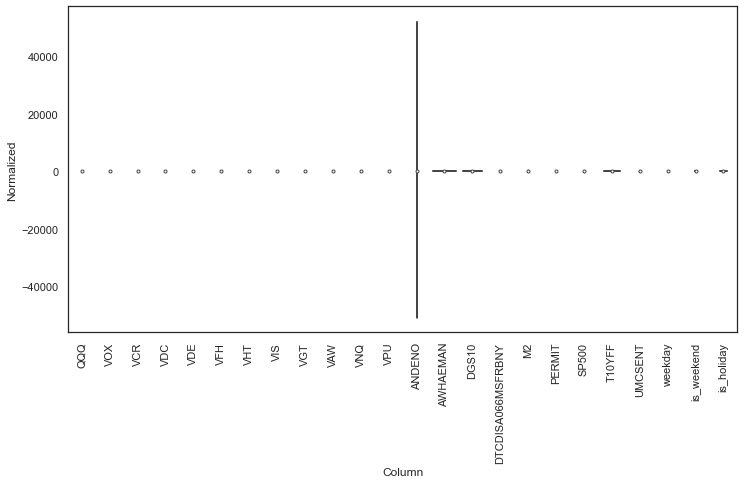

In [232]:
# # normalize data
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

# # check distribution
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

#  normalize data
# use one degree difference rather than normalization to improve the accuracy of prediction
train_mean = train_df.mean()
train_std = train_df.std()

train_df = train_df.diff(1).dropna()
val_df = val_df.diff(1).dropna()
test_df = test_df.diff(1).dropna()

# check distribution
df_std = df.diff(1).dropna()
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)



### Data Windowing

In [233]:
# generate window
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [234]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=[target_etf])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['VFH']

In [235]:
w2 = WindowGenerator(input_width=n_input_width, label_width=1, shift=1,
                     label_columns=[target_etf])
w2

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

In [236]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [237]:
# Stack three slices, the length of the total window:
example_window = tf.stack([
    
                           np.array(train_df[-3*w2.total_window_size:-2*w2.total_window_size]),
                           np.array(train_df[-2*w2.total_window_size:-w2.total_window_size]),
                           np.array(train_df[-w2.total_window_size:])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 31, 24)
Inputs shape: (3, 30, 24)
labels shape: (3, 1, 1)


In [238]:
w2.example = example_inputs, example_labels


In [239]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Date [d]')

WindowGenerator.plot = plot

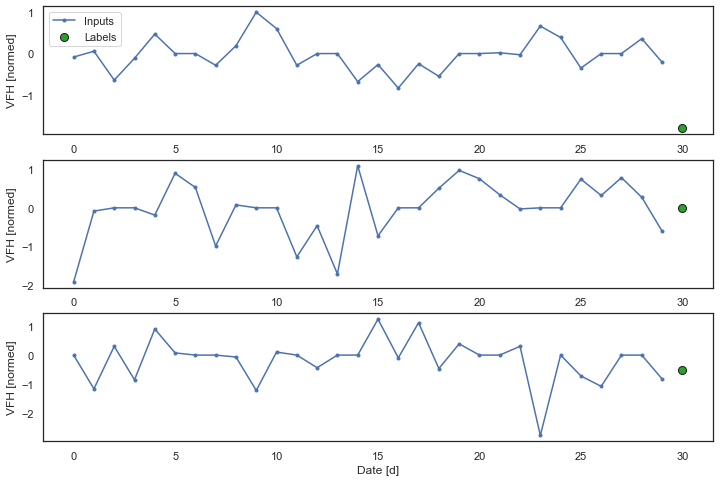

In [240]:
w2.plot(plot_col=target_etf,max_subplots=6)

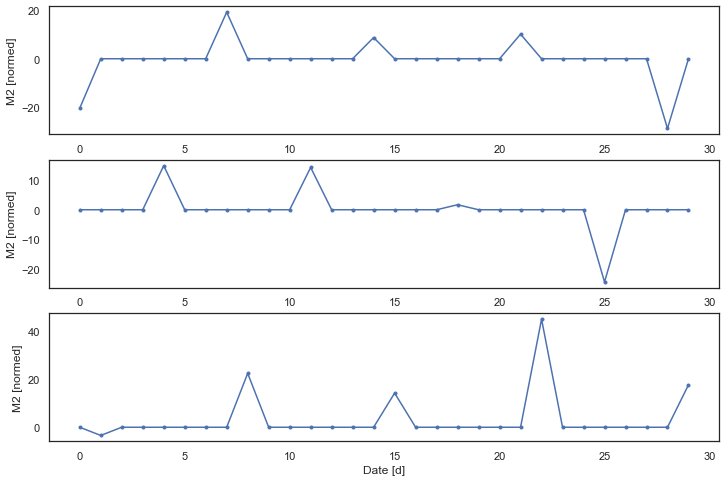

In [241]:
w2.plot(plot_col='M2')


In [242]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [243]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [244]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 30, 24), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [245]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 24)
Labels shape (batch, time, features): (32, 1, 1)


In [246]:
single_step_window = WindowGenerator(
    input_width=n_input_width, label_width=1, shift=1,
    label_columns=[target_etf])
single_step_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

In [247]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 24)
Labels shape (batch, time, features): (32, 1, 1)


In [248]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [249]:
# baseline model that use current value
baseline = Baseline(label_index=column_indices[target_etf])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

16/16 [==============================] - 0s 2ms/step - loss: 2.6058 - mean_absolute_error: 0.8879


In [250]:
wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1,
    label_columns=[target_etf])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['VFH']

In [251]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 24)
Output shape: (32, 30, 1)


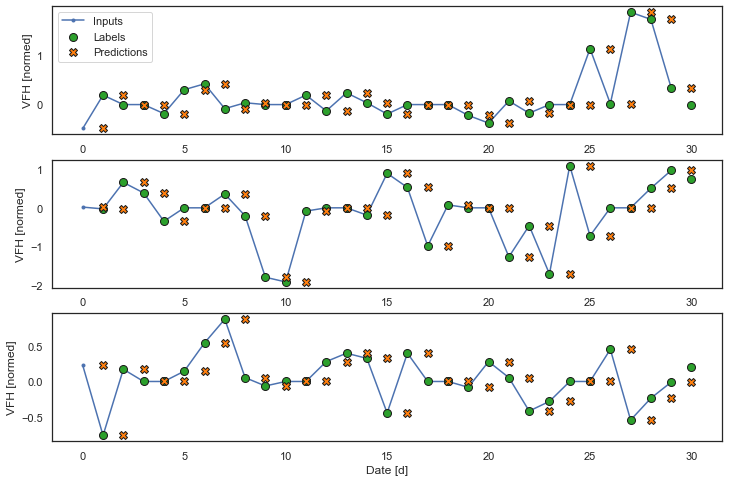

In [252]:
# Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

wide_window.plot(baseline,target_etf)

In [253]:
# Linear model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [254]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 30, 24)
Output shape: (32, 30, 1)


In [255]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
    return history

In [256]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
56/56 [==============================] - 1s 9ms/step - loss: 350061.3092 - mean_absolute_error: 59.4976 - val_loss: 111340.4141 - val_mean_absolute_error: 44.0970
Epoch 2/20
56/56 [==============================] - 0s 4ms/step - loss: 253388.6003 - mean_absolute_error: 50.8883 - val_loss: 76315.3906 - val_mean_absolute_error: 36.3617
Epoch 3/20
56/56 [==============================] - 0s 5ms/step - loss: 183601.8512 - mean_absolute_error: 42.9736 - val_loss: 51493.2578 - val_mean_absolute_error: 29.7673
Epoch 4/20
56/56 [==============================] - 0s 5ms/step - loss: 119914.9678 - mean_absolute_error: 34.3851 - val_loss: 32951.8359 - val_mean_absolute_error: 23.8026
Epoch 5/20
56/56 [==============================] - 0s 5ms/step - loss: 78950.0772 - mean_absolute_error: 28.3308 - val_loss: 20436.0742 - val_mean_absolute_error: 18.9199
Epoch 6/20
56/56 [==============================] - 0s 5ms/step - loss: 44565.0143 - mean_absolute_error: 21.3854 - val_loss: 12199.338

In [257]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 30, 24)
Output shape: (32, 30, 1)


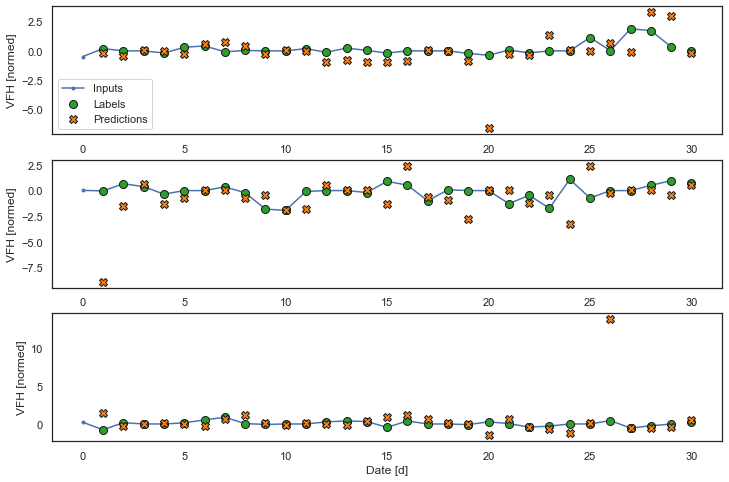

In [258]:
wide_window.plot(linear,target_etf)


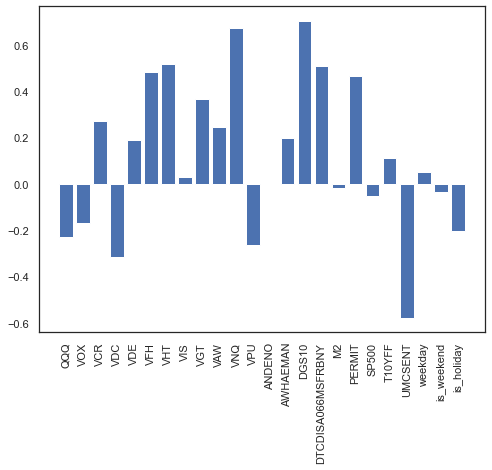

In [259]:
# pull out the layer's weights, and see the weight assigned to each input:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [260]:
# Dense
# checking the performance of deeper, more powerful, single input step models.
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
56/56 [==============================] - 1s 11ms/step - loss: 3372.5252 - mean_absolute_error: 4.8944 - val_loss: 15.3624 - val_mean_absolute_error: 1.0957
Epoch 2/20
56/56 [==============================] - 0s 6ms/step - loss: 7.3065 - mean_absolute_error: 0.5545 - val_loss: 8.2990 - val_mean_absolute_error: 0.8422
Epoch 3/20
56/56 [==============================] - 0s 7ms/step - loss: 1.5472 - mean_absolute_error: 0.4181 - val_loss: 5.9248 - val_mean_absolute_error: 0.7936
Epoch 4/20
56/56 [==============================] - 0s 7ms/step - loss: 2.9516 - mean_absolute_error: 0.4152 - val_loss: 4.3181 - val_mean_absolute_error: 0.7246
Epoch 5/20
56/56 [==============================] - 0s 6ms/step - loss: 0.8014 - mean_absolute_error: 0.3624 - val_loss: 2.9092 - val_mean_absolute_error: 0.6812
Epoch 6/20
56/56 [==============================] - 0s 6ms/step - loss: 0.5532 - mean_absolute_error: 0.3326 - val_loss: 2.2802 - val_mean_absolute_error: 0.6776
Epoch 7/20
56/56 [=====

In [261]:
CONV_WIDTH = n_input_width
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[target_etf])

conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['VFH']

Text(0.5, 1.0, 'Given 30d as input, predict 1d into the future.')

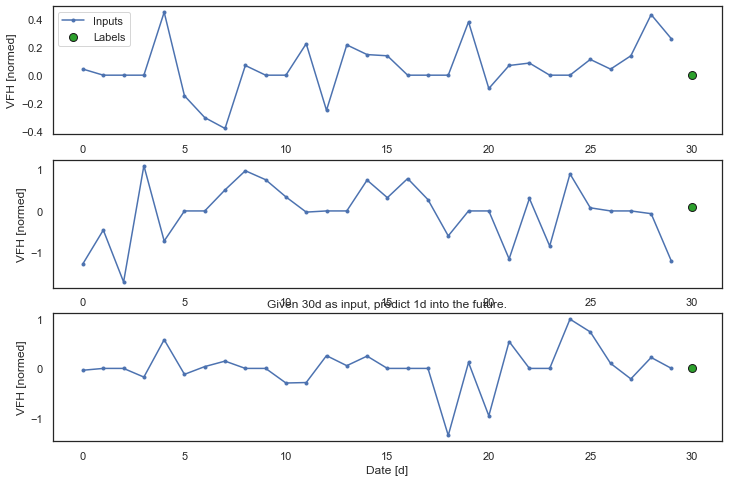

In [262]:
conv_window.plot(plot_col=target_etf)
plt.title(f"Given {n_input_width}d as input, predict 1d into the future.")

In [263]:
# multi step dense
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [264]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 30, 24)
Output shape: (32, 1, 1)


In [265]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

16/16 [==============================] - 0s 2ms/step - loss: 2422.2766 - mean_absolute_error: 23.4624


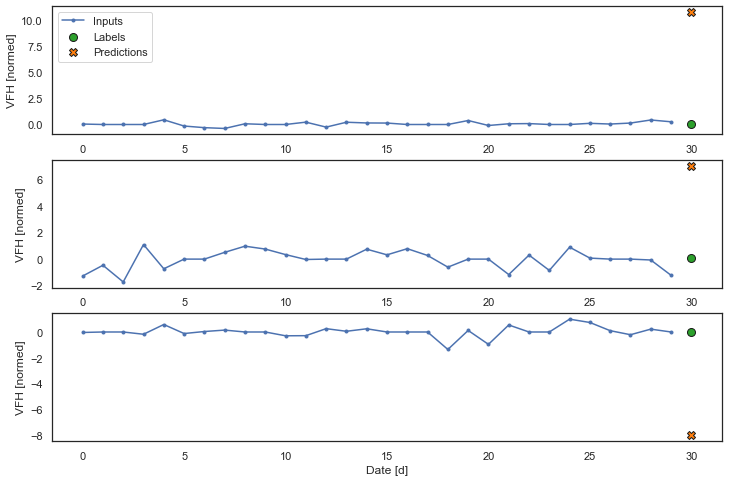

In [266]:
conv_window.plot(multi_step_dense, target_etf)

In [267]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 30, 24)
Output shape: (32, 1, 1)


In [268]:
# Convolution neural network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [269]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 30, 24)
Output shape: (32, 1, 1)


In [270]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

16/16 [==============================] - 0s 2ms/step - loss: 506.9150 - mean_absolute_error: 9.7497


In [271]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 30, 24)
Labels shape: (32, 30, 1)
Output shape: (32, 1, 1)


In [272]:
LABEL_WIDTH = n_input_width
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[target_etf])

wide_conv_window

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['VFH']

In [273]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 59, 24)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


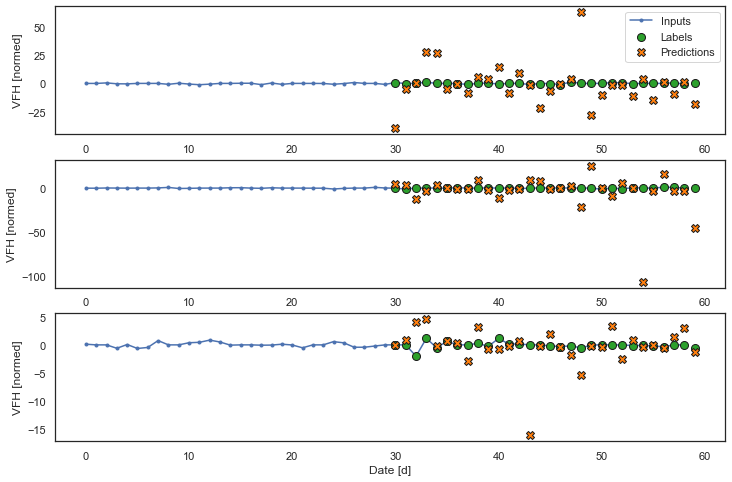

In [274]:
wide_conv_window.plot(conv_model,target_etf)


In [275]:
# Recurrent neural network
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [276]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 24)
Output shape: (32, 30, 1)


In [277]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


16/16 [==============================] - 0s 4ms/step - loss: 1.1361 - mean_absolute_error: 0.5607


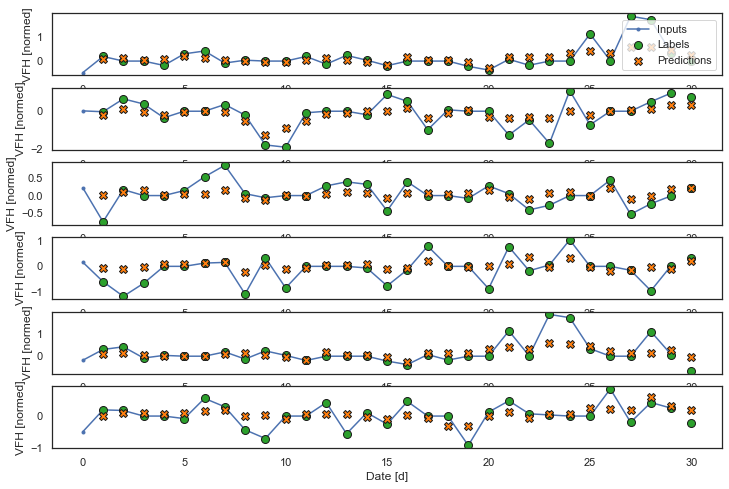

In [278]:
wide_window.plot(lstm_model,target_etf,max_subplots=6)

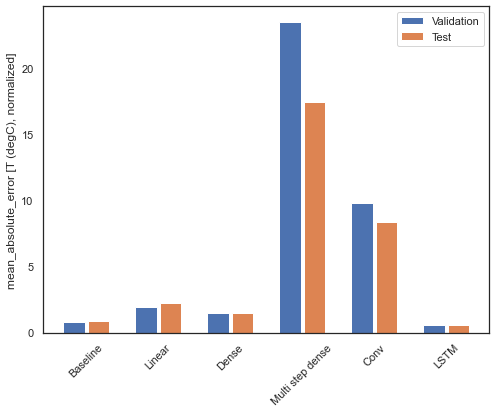

In [279]:
# Performance
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [280]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.8950
Linear      : 2.2537
Dense       : 1.4410
Multi step dense: 17.3944
Conv        : 8.3224
LSTM        : 0.5935


### Single step models

In [281]:
# Multi-output models
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 24)
Labels shape (batch, time, features): (32, 30, 24)


In [282]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [283]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

16/16 [==============================] - 0s 2ms/step - loss: 164922.7040 - mean_absolute_error: 16.9109


In [284]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [285]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

17/17 [==============================] - 0s 2ms/step - loss: 84998.4141 - mean_absolute_error: 10.5918


In [286]:
%%time
wide_window = WindowGenerator(
    input_width=n_input_width, label_width=n_input_width, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

16/16 [==============================] - 0s 3ms/step - loss: 79734.3203 - mean_absolute_error: 9.0460

CPU times: user 20 s, sys: 3.37 s, total: 23.4 s
Wall time: 12.7 s


In [287]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [288]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

16/16 [==============================] - 0s 4ms/step - loss: 158841.0781 - mean_absolute_error: 17.2814

CPU times: user 34 s, sys: 6.15 s, total: 40.2 s
Wall time: 20.4 s


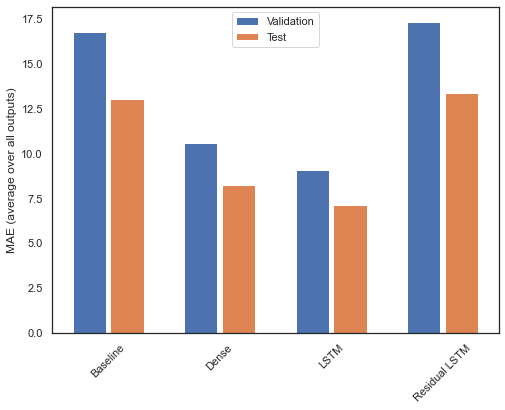

In [289]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [290]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 13.0014
Dense          : 8.2224
LSTM           : 7.1247
Residual LSTM  : 13.3677


## Multi-step models

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None

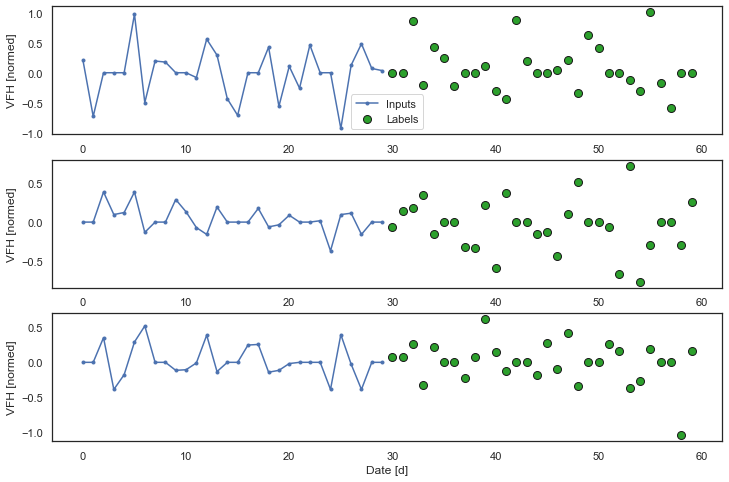

In [291]:
OUT_STEPS = n_input_width
multi_window = WindowGenerator(input_width=n_input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot(plot_col=target_etf)
multi_window

### Baseline

15/15 [==============================] - 0s 2ms/step - loss: 208531.7643 - mean_absolute_error: 18.0611


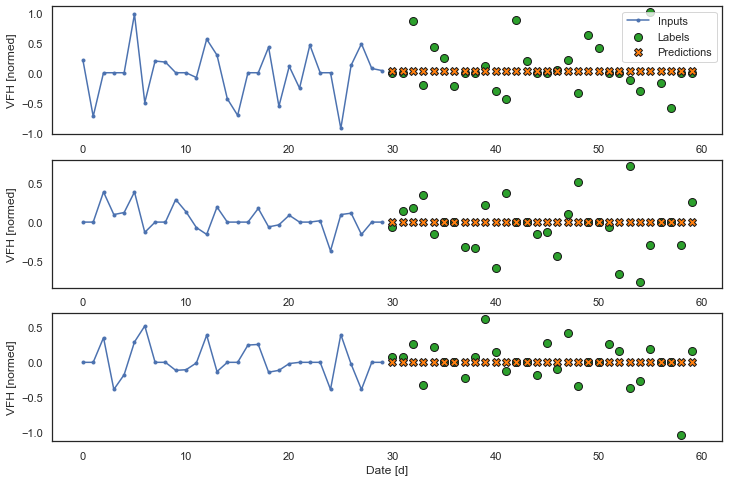

In [292]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline, plot_col=target_etf)

15/15 [==============================] - 0s 2ms/step - loss: 156121.2959 - mean_absolute_error: 15.1955


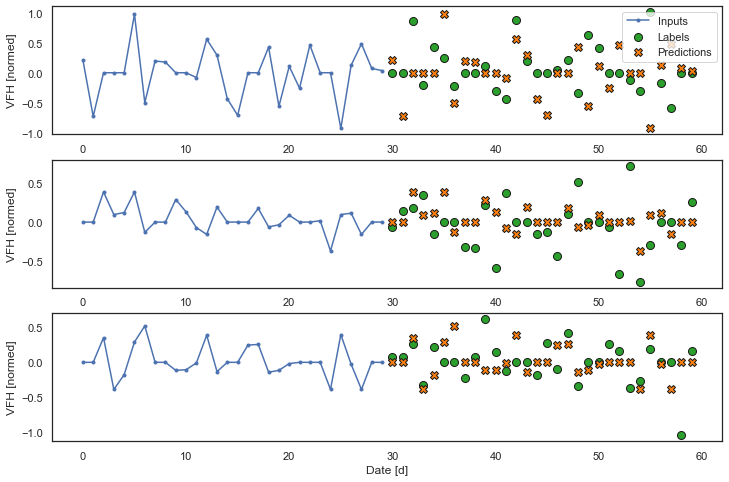

In [293]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline, plot_col=target_etf)

### Single-shot models

15/15 [==============================] - 0s 2ms/step - loss: 83489.2188 - mean_absolute_error: 9.2129


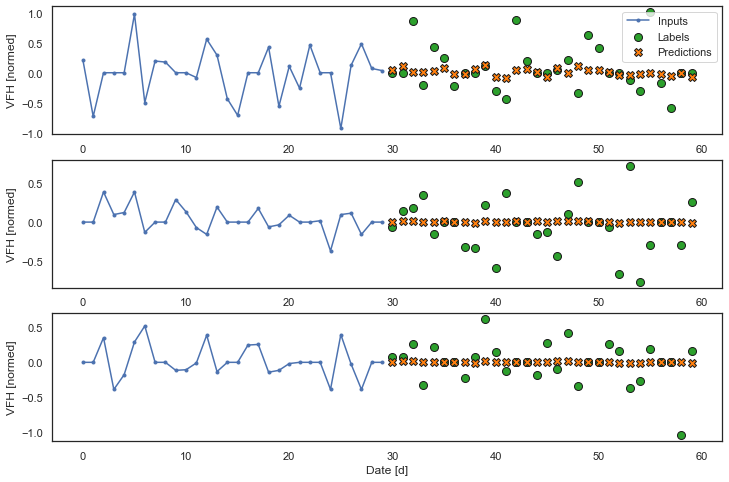

In [294]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model, plot_col=target_etf)

### Dense

15/15 [==============================] - 0s 2ms/step - loss: 83493.5312 - mean_absolute_error: 9.3487


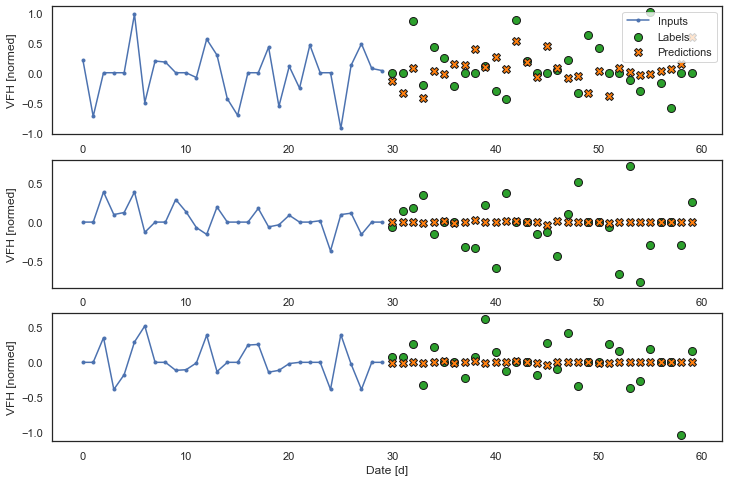

In [295]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model, plot_col=target_etf)

15/15 [==============================] - 0s 2ms/step - loss: 83492.6797 - mean_absolute_error: 9.4735


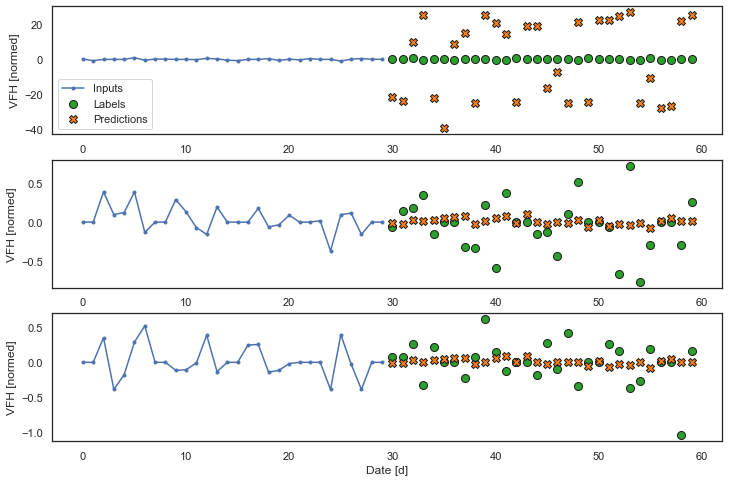

In [296]:
# CNN
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model, plot_col=target_etf)

15/15 [==============================] - 0s 4ms/step - loss: 83472.3281 - mean_absolute_error: 8.9260


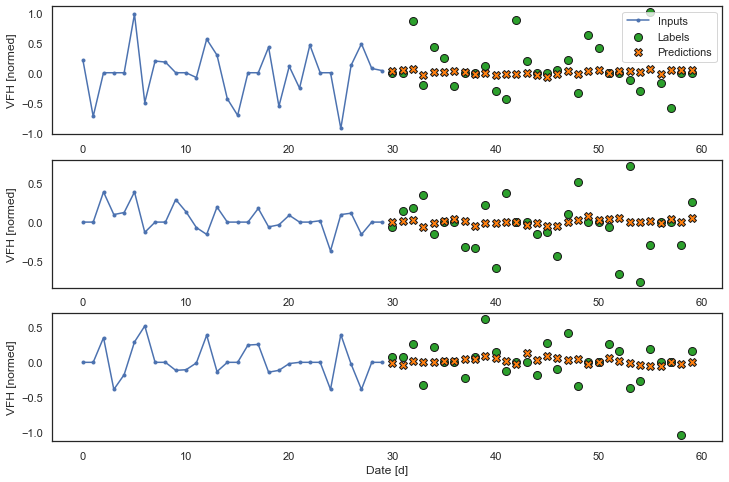

In [297]:
# RNN
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model, plot_col=target_etf)

### Advanced: Autoregressive model

In [298]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [299]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [300]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [301]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 24])

In [302]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [303]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 30, 24)


15/15 [==============================] - 0s 6ms/step - loss: 83433.8672 - mean_absolute_error: 10.1110


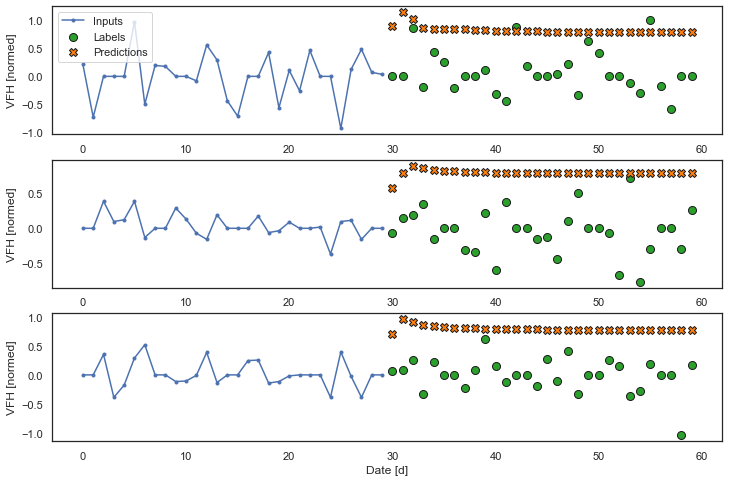

In [304]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model, plot_col=target_etf)

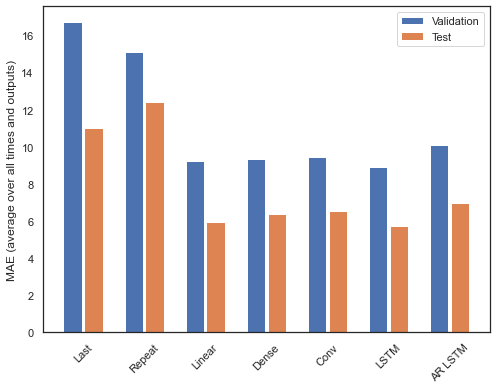

In [305]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [306]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 11.0046
Repeat  : 12.4131
Linear  : 5.9547
Dense   : 6.3669
Conv    : 6.5191
LSTM    : 5.7450
AR LSTM : 6.9523


### Predict

In [307]:
# transform data to create prediction

# final_window = single_step_window
# final_model = dense

# final_window = wide_window
# final_model = lstm_model

final_window = multi_window
final_model = multi_lstm_model #multi_lstm_model # or multi_linear_model #

final_window_size = final_window.input_width


# actual_df_std = (df - train_mean) / train_std
actual_df_std = df.diff(diff_order).dropna()
actual_df_std = actual_df_std[-final_window_size:]



In [308]:
# create prediction
def make_pred_dataset(self, data):
#     data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.input_width,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
    return ds

WindowGenerator.make_pred_dataset = make_pred_dataset

predictions = final_model.predict(final_window.make_pred_dataset(actual_df_std))
# predictions = final_model.predict([np.array(actual_df_std, dtype=np.float32)])
print("predictions shape:", predictions.shape)   

predictions shape: (1, 30, 24)


In [309]:
# reverse the prediction
predictions_reversed = pd.DataFrame(data = predictions[0],columns=plot_cols)
# method to reverse prediction to the original scale as we used 1 degree difference to preprocess data
predictions_reversed = np.cumsum(predictions_reversed,axis=0)  + df[-1:].values
# method to reverse prediction to the original scale if we used normalization to preprocess data
# predictions_reversed = predictions_reversed*train_std+train_mean

predictions_reversed.index = pd.date_range(forecast_start_date,periods=predictions_reversed.shape[0],freq='D').date

In [310]:
# compare current with predicted future
current_reversed = df.copy()
# current_reversed = actual_df_std.copy()
current = current_reversed[etf_list].tail(1).values
future1 = np.array(predictions_reversed[etf_list].mean())
future2 = predictions_reversed[etf_list].tail(1).values
future_tomorrow = predictions_reversed[etf_list].head(1).values

In [311]:
print("The higher the number of rank, the more recomended to invest in:")
pd.DataFrame(data={'etf':etf_list,
                   '% change by mean':(future1/current-1)[0], 
                   'rank1': rankdata((future1/current-1)[0], method='min'),
                   '% change by last value':(future2/current-1)[0],
                  'rank2': rankdata((future2/current-1)[0], method='min'),
                    '% change by tomorrow':(future_tomorrow/current-1)[0],
                  'rank3': rankdata((future_tomorrow/current-1)[0], method='min')
                  })


The higher the number of rank, the more recomended to invest in:


etf  % change by mean  rank1  % change by last value  rank2  \
0   QQQ            0.0040      4                  0.0058      7   
1   VOX            0.0043      7                  0.0039      3   
2   VCR            0.0038      3                  0.0050      6   
3   VDC            0.0053     10                  0.0068     10   
4   VDE            0.0005      1                 -0.0095      1   
5   VFH            0.0044      8                  0.0044      4   
6   VHT            0.0046      9                  0.0066      9   
7   VIS            0.0041      6                  0.0047      5   
8   VGT            0.0041      5                  0.0063      8   
9   VAW            0.0033      2                  0.0031      2   
10  VNQ            0.0105     12                  0.0169     12   
11  VPU            0.0067     11                  0.0110     11   

    % change by tomorrow  rank3  
0                 0.0002     10  
1                 0.0001      6  
2                 0.0001      4  
3                 0.0001      8  
4                -0.0002      2  
5                -0.0002      1  
6                 0.0000      3  
7                 0.0001      5  
8                 0.0002      9  
9                 0.0001      7  
10                0.0008     12  
11                0.0003     11

In [312]:
# plot the current and predicted future
final_actual = current_reversed[etf_list+leading_metric_list].copy()
final_actual['Type'] = 'Actual'
final_pred = predictions_reversed[etf_list+leading_metric_list].copy()
final_pred['Type'] = 'Prediction'

final_df = final_actual.append(final_pred)
final_df['Created Date']=train_end_date

In [313]:
# store the actual and prediction
final_df.to_csv(os.path.join(project_dir, f'data/processed/ts_leading_metric_impact_on_sectors_pred_{train_end_date}.csv'), encoding='utf-8', index=False)


## Visualization

In [314]:
# visualize ETFs
# colors
palette = cycle(px.colors.qualitative.Bold)

max_y = final_df[etf_list].max().max()
n_digit = 10 ** (len(str(int(max_y)))-1)
data = []
for etf in etf_list:
    trace_color = next(palette)
    # TODO: add ETF name
    trace_actual = go.Scatter(x=final_actual.index, y=final_actual[etf],
                    mode='lines',
                    name=f'{etf}-actual',
                             line=go.Line(color=trace_color,
                                         width=1.5,))
    trace_pred = go.Scatter(x=final_pred.index, y=final_pred[etf],
                    mode='lines',
                    name=f'{etf}-prediction',
                           line=go.Line(color=trace_color,
                                       width=1.5,
                                       dash='dashdot'))
    data.append(trace_actual)
    data.append(trace_pred)

layout = go.Layout(title='ETF',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Value'))
layout.update(dict(shapes=[
    {
        'type':'line',
        'x0':train_end_date,
        'y0':0,
        'x1':train_end_date,
        'y1':np.ceil(max_y/n_digit)*n_digit,
        'line':{
            'color':'#909090',
            'width':1
        }
        
    }
]))
layout.update(dict(annotations=[
    go.Annotation(text='End of training',
                 x=train_end_date,
                 y=np.floor(max_y/n_digit)*n_digit
                  )
]))
fig = go.Figure(data = data,layout=layout)

fig.show()

In [315]:
# visualize leading metrics


# colors
palette = cycle(px.colors.qualitative.Vivid)

max_y = final_df[leading_metric_list].max().max()
n_digit = 10 ** (len(str(int(max_y)))-1)
data = []
for leading_metric in leading_metric_list:
    trace_color = next(palette)
    trace_actual = go.Scatter(x=final_actual.index, y=final_actual[leading_metric],
                    mode='lines',
                    name=f'{leading_metric}-actual',
                             line=go.Line(color=trace_color,
                                         width=1.5,))
    trace_pred = go.Scatter(x=final_pred.index, y=final_pred[leading_metric],
                    mode='lines',
                    name=f'{leading_metric}-prediction',
                           line=go.Line(color=trace_color,
                                       width=1.5,
                                       dash='dashdot'))
    data.append(trace_actual)
    data.append(trace_pred)

layout = go.Layout(title='Leading Metrics',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Value'))
layout.update(dict(shapes=[
    {
        'type':'line',
        'x0':train_end_date,
        'y0':0,
        'x1':train_end_date,
        'y1':np.ceil(max_y/n_digit)*n_digit,
        'line':{
            'color':'#909090',
            'width':1
        }
        
    }
]))
layout.update(dict(annotations=[
    go.Annotation(text='End of training',
                 x=train_end_date,
                 y=np.floor(max_y/n_digit)*n_digit
                  )
]))
fig = go.Figure(data = data,layout=layout)

fig.show()